In [69]:
import numpy
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.transforms import ToTensor
from torch import nn
from torch.utils.data import DataLoader

In [70]:
# datasets: 'digits', 'fashion'
dataset = 'digits'

In [71]:
if dataset == 'digits':
    data = torchvision.datasets.MNIST(
        root='data',
        train=True,
        download=True,
        transform=ToTensor()
    )

    test_data = torchvision.datasets.MNIST(
        root='data',
        train=False,
        download=True,
        transform=ToTensor()
    )
    labels_map = {
        0: "0",
        1: "1",
        2: "2",
        3: "3",
        4: "4",
        5: "5",
        6: "6",
        7: "7",
        8: "8",
        9: "9",
    }
elif dataset == 'fashion':
    data = torchvision.datasets.FashionMNIST(
        root='data',
        train=True,
        download=True,
        transform=ToTensor()
    )

    test_data = torchvision.datasets.FashionMNIST(
        root='data',
        train=False,
        download=True,
        transform=ToTensor()
    )
    labels_map = {
        0: "T-Shirt",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
    }

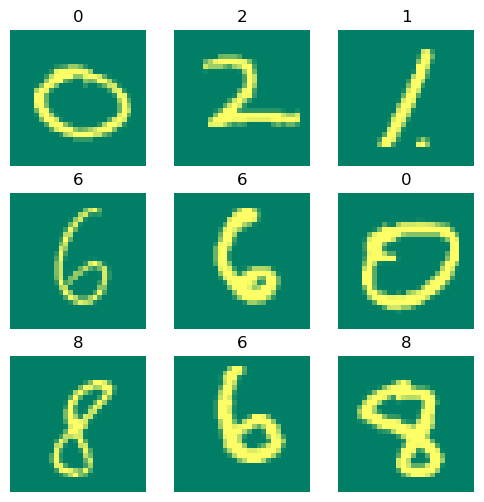

In [72]:
figure = plt.figure(figsize=(6,6))
cols, rows = 3, 3
for i in range(1, cols*rows + 1):
    sample_index = torch.randint(len(data), size=(1,)).item()
    img, label = data[sample_index]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.title(labels_map[label])
    plt.imshow(img.squeeze(), cmap="summer")
plt.show()


In [73]:
data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [96]:
class VarAutoencoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28+10, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2+10, 20),
            nn.ReLU(),
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
        self.linear1 = nn.Linear(20, 2)
        self.linear2 = nn.Linear(20, 2)
        self.G = torch.distributions.Normal(0, 1)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        return mu + std*self.G.sample(mu.shape)

    def sample(self, digit=None):
        " Generate a new digit, optional: digit (int)"
        if digit is None:
            digit = numpy.random.randint(0, 10)
        y = nn.functional.one_hot(torch.tensor(digit), num_classes=10)
        z = torch.randn(2)
        z_cond = torch.cat((z, y))
        return self.decoder(z_cond), digit

    def forward(self, x, y):
        x_cond = torch.cat((x,y), dim=1)
        x = self.encoder(x_cond)
        mu = self.linear1(x)
        logvar = self.linear2(x)
        z = self.reparametrize(mu, logvar)
        z_cond = torch.cat((z, y), dim=1)
        output = self.decoder(z_cond)
        return output, mu, logvar

    def generate_digits(self):
        for j in range(10):
            fig = plt.figure(figsize=(14,10))
            with torch.no_grad():
                for i in range(10):
                    x, _ = self.sample(j)
                    ax = fig.add_subplot(1,10,i+1)
                    ax.imshow(x.squeeze().reshape(28,28), cmap='pink')
            plt.title(j)
            plt.show()

VAE = VarAutoencoder()

In [97]:
learning_rate = 1e-4
batch_size = 32

In [98]:
loss_1 = nn.MSELoss()
def loss_2(mu, logvar):
    return torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - torch.exp(logvar), dim = 1), dim = 0).sum()

In [99]:
#optimizer = torch.optim.SGD(ae.parameters(), lr=learning_rate, momentum=momentum)
optimizer = torch.optim.Adam(VAE.parameters(),
                             lr = learning_rate,
                             weight_decay = 1e-8)
data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)

Epoch  0
loss1 tensor(0.2319) loss2 tensor(0.0269)
[ 5  8 23 12]


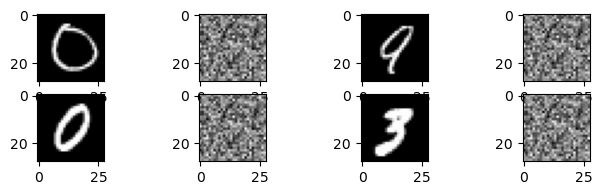

2.318814992904663
Epoch  1
loss1 tensor(0.0626) loss2 tensor(1.1563)
[24 30  3 12]


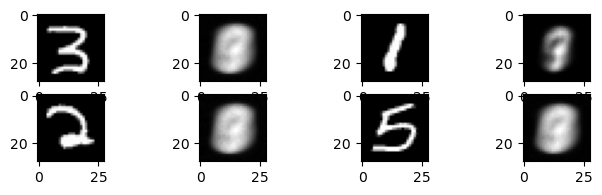

0.6315116882324219
Epoch  2
loss1 tensor(0.0586) loss2 tensor(1.7091)
[ 8 17  7 24]


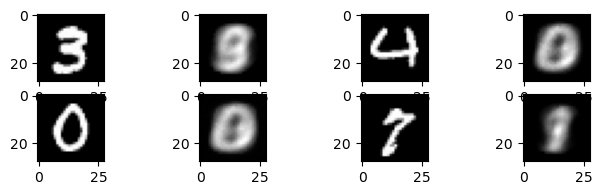

0.5949838161468506
Epoch  3
loss1 tensor(0.0599) loss2 tensor(2.2926)
[12  2 14 18]


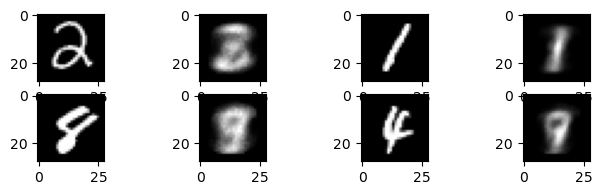

0.6106428503990173
Epoch  4
loss1 tensor(0.0502) loss2 tensor(3.1303)
[15 25 29 25]


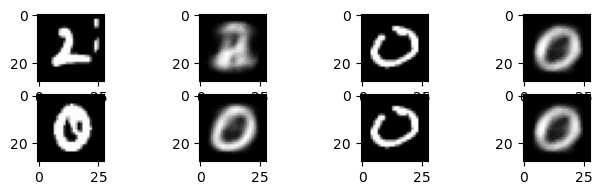

0.5176458358764648
Epoch  5
loss1 tensor(0.0476) loss2 tensor(3.0360)
[27  6  6 11]


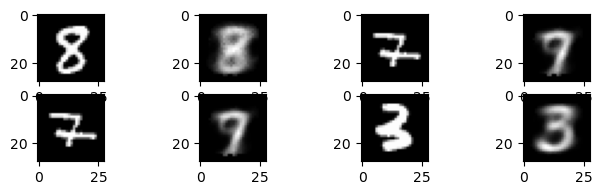

0.49155765771865845
Epoch  6
loss1 tensor(0.0466) loss2 tensor(3.1372)
[17  2 25  7]


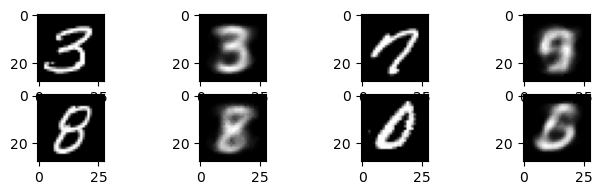

0.48170074820518494
Epoch  7
loss1 tensor(0.0489) loss2 tensor(3.4798)
[13 29 23  5]


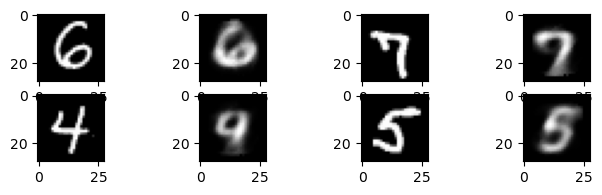

0.5066973567008972
Epoch  8
loss1 tensor(0.0411) loss2 tensor(3.8384)
[28 12  1 21]


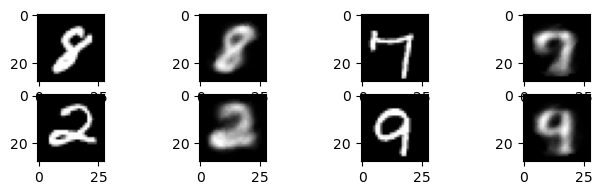

0.4304158091545105
Epoch  9
loss1 tensor(0.0458) loss2 tensor(3.6639)
[22 26 24  4]


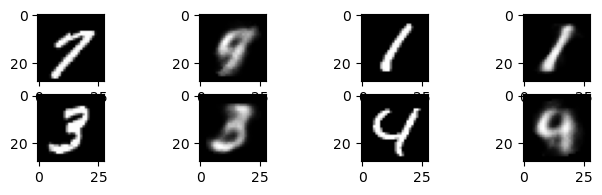

0.4763408899307251
Epoch  10
loss1 tensor(0.0414) loss2 tensor(3.5814)
[18 19  2 12]


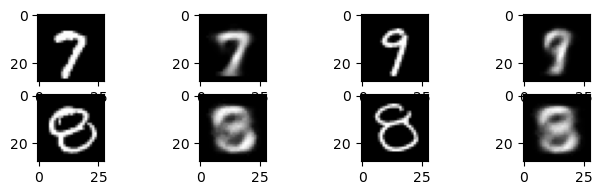

0.4318466782569885
Epoch  11
loss1 tensor(0.0391) loss2 tensor(3.6189)
[ 5  4 26 31]


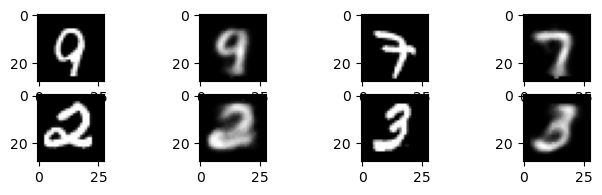

0.40876126289367676
Epoch  12
loss1 tensor(0.0436) loss2 tensor(3.7764)
[26  2 23 28]


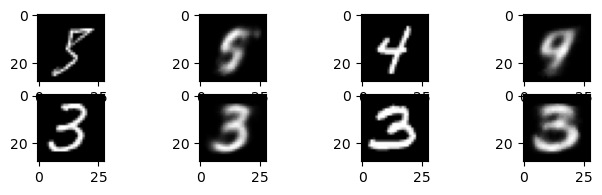

0.45505982637405396
Epoch  13
loss1 tensor(0.0419) loss2 tensor(4.0934)
[21 10 17  1]


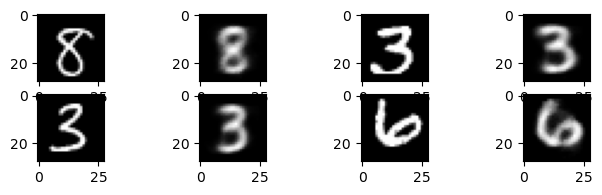

0.439253032207489
Epoch  14
loss1 tensor(0.0400) loss2 tensor(3.8042)
[ 2 11  0 18]


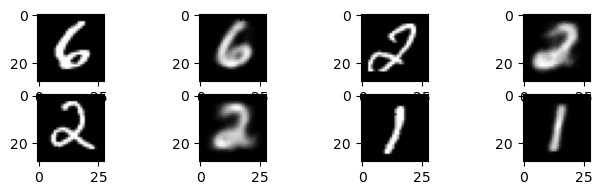

0.4188539683818817
Epoch  15
loss1 tensor(0.0413) loss2 tensor(3.8664)
[17 31  3 19]


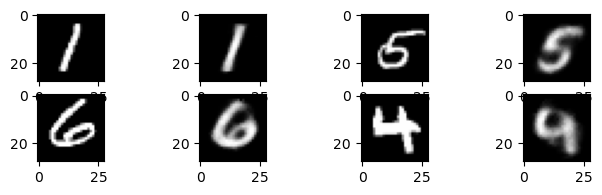

0.43233227729797363
Epoch  16
loss1 tensor(0.0366) loss2 tensor(3.9646)
[ 2 28 16 20]


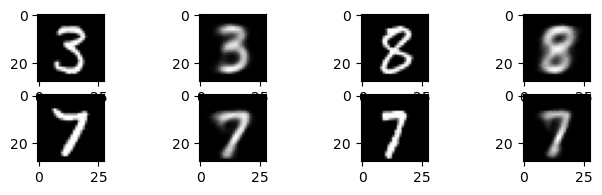

0.38616928458213806
Epoch  17
loss1 tensor(0.0377) loss2 tensor(3.8516)
[10 17 14 15]


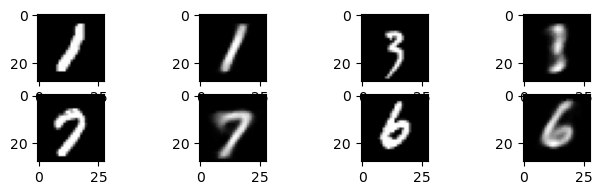

0.39663636684417725
Epoch  18
loss1 tensor(0.0382) loss2 tensor(3.9513)
[ 0  5 10 10]


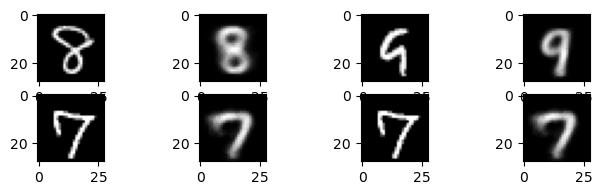

0.40136393904685974
Epoch  19
loss1 tensor(0.0371) loss2 tensor(4.0017)
[17  9 22  0]


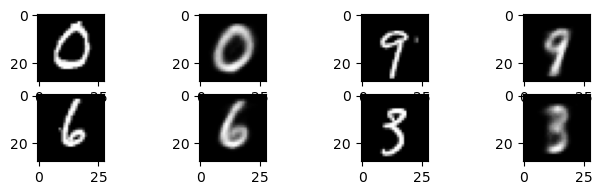

0.3908134996891022
Epoch  20
loss1 tensor(0.0389) loss2 tensor(4.0906)
[10 13 28 12]


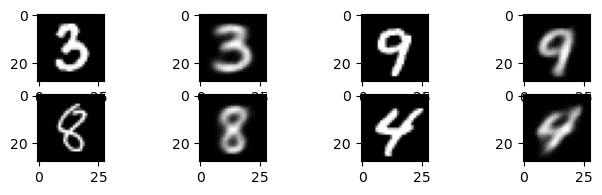

0.40985721349716187
Epoch  21
loss1 tensor(0.0365) loss2 tensor(4.3065)
[ 6  1 22 10]


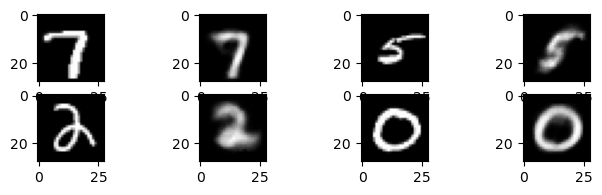

0.3866114020347595
Epoch  22
loss1 tensor(0.0375) loss2 tensor(4.0809)
[22 24 26 11]


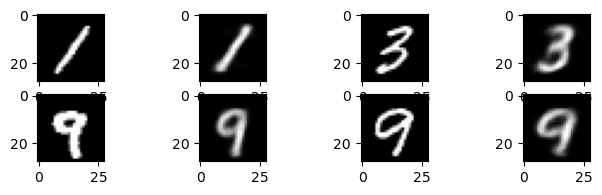

0.3949090838432312
Epoch  23
loss1 tensor(0.0378) loss2 tensor(4.2366)
[12  6  3  6]


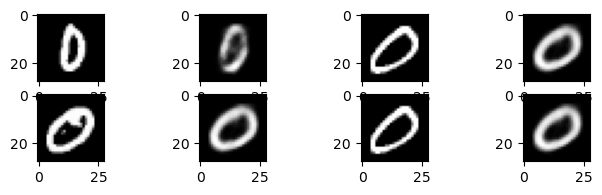

0.39924100041389465
Epoch  24
loss1 tensor(0.0377) loss2 tensor(4.1716)
[ 1 16 18 14]


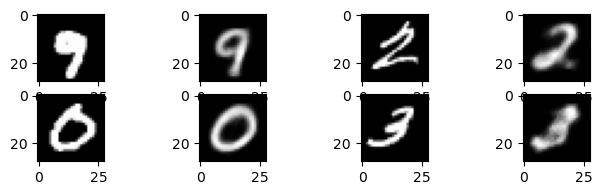

0.39796182513237
Epoch  25
loss1 tensor(0.0382) loss2 tensor(4.0409)
[8 1 2 9]


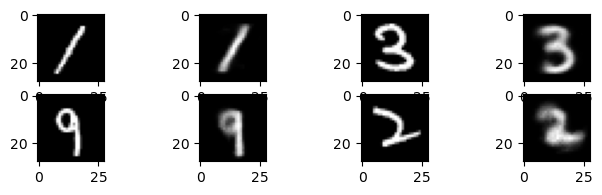

0.40170976519584656
Epoch  26
loss1 tensor(0.0345) loss2 tensor(4.3124)
[ 2  7  2 15]


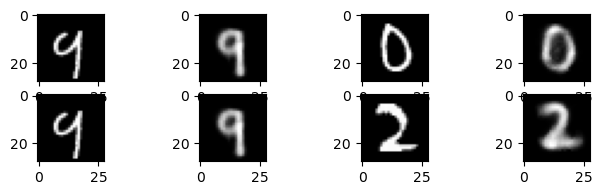

0.3670365810394287
Epoch  27
loss1 tensor(0.0405) loss2 tensor(4.4325)
[8 4 7 2]


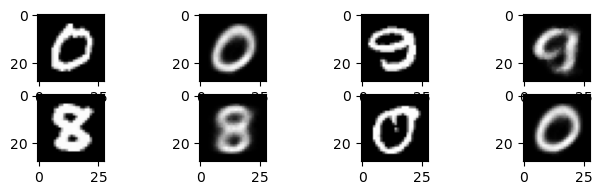

0.42668020725250244
Epoch  28
loss1 tensor(0.0411) loss2 tensor(4.6066)
[16  3 20 18]


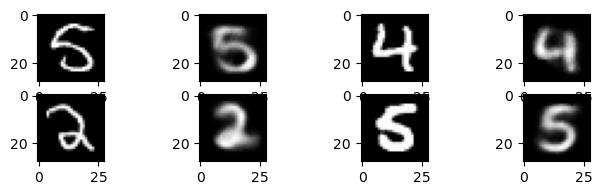

0.4338238835334778
Epoch  29
loss1 tensor(0.0402) loss2 tensor(4.1489)
[26 27 10 21]


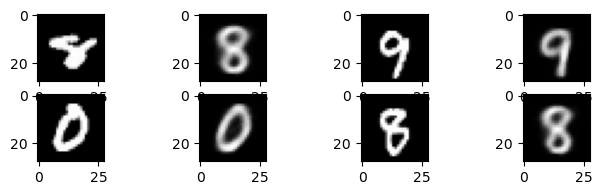

0.4226722717285156


In [100]:
# Training loop
epochs = 30
losses = []
beta1 = 10
beta2 = 0.005
for epoch in range(epochs):
    plot = True
    VAE.train()
    for (image, label) in data_loader:

        # Reshape image, label for input
        image = image.reshape(-1, 784)
        label = nn.functional.one_hot(label, num_classes=10)
        # Feed through the network
        reconstruction, mu, logvar = VAE(image, label)
        # Calculate loss function
        loss = beta1*loss_1(reconstruction, image) + beta2*loss_2(mu, logvar)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if plot==True:
            fig = plt.figure(figsize=(8,4))
            print('Epoch ', epoch)
            with torch.no_grad():
                print('loss1', loss_1(reconstruction, image), 'loss2', loss_2(mu, logvar))
                recon_plot = reconstruction.reshape(-1, 28, 28)
                images_plot = image.reshape(-1, 28, 28)
                indices = numpy.random.choice(32, 4)
                print(indices)
                for i, ind in enumerate(indices):
                    ax1 = fig.add_subplot(4,4,2*i+1)
                    ax1.imshow(images_plot[ind], cmap='gray')
                    ax2 = fig.add_subplot(4,4,2*i+2)
                    ax2.imshow(recon_plot[ind], cmap='gray')
            
            plt.show()
            print(losses[-1])
            plot=False        

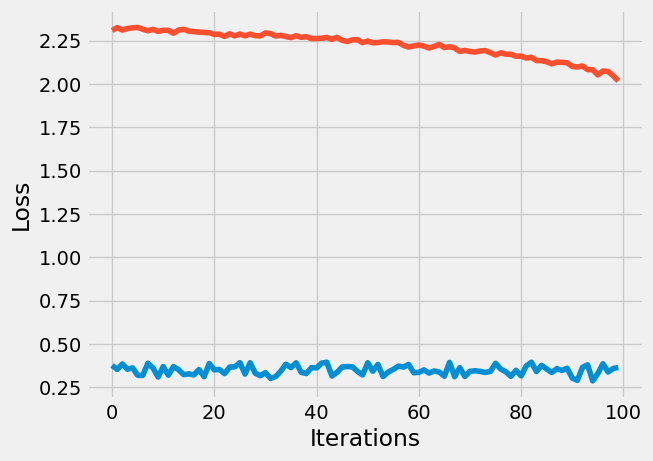

In [170]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
# Plotting the last 100 values
plt.plot(losses[-100:])
plt.plot(losses[:100])

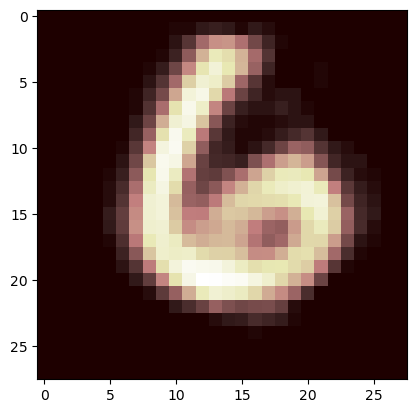

In [105]:
img, _ = VAE.sample(6)
plt.imshow(img.detach().reshape(28,28), cmap='pink')

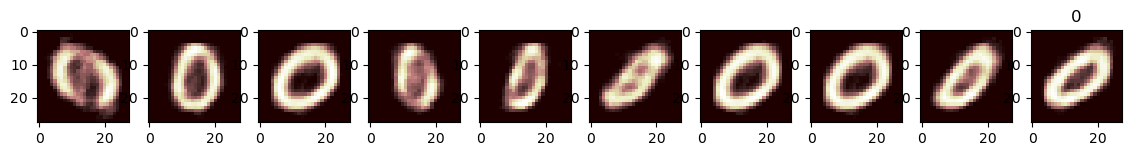

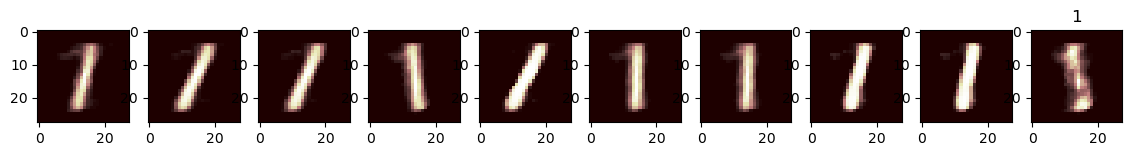

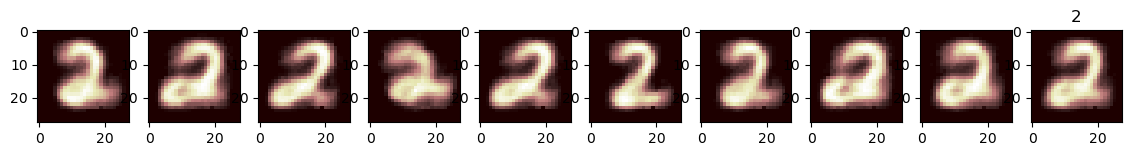

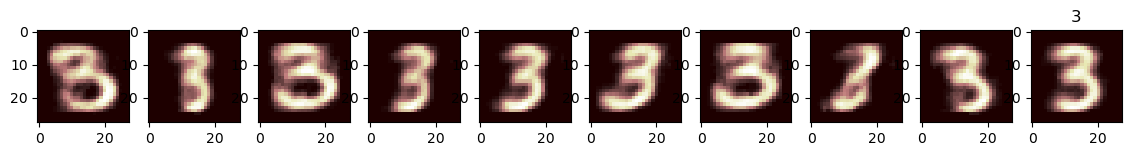

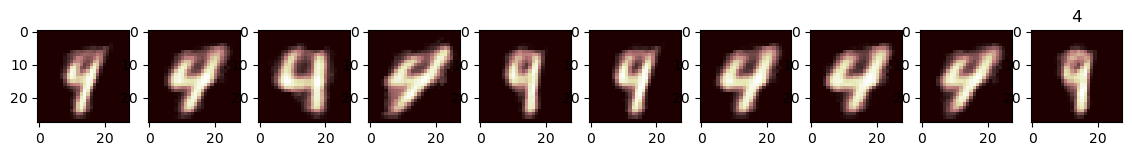

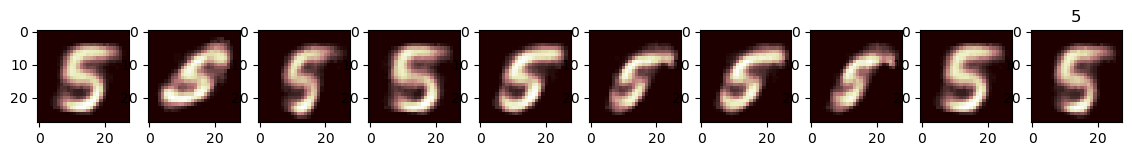

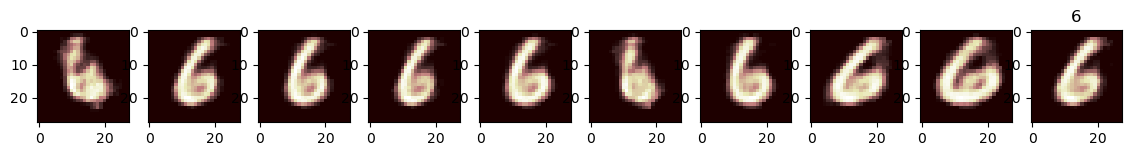

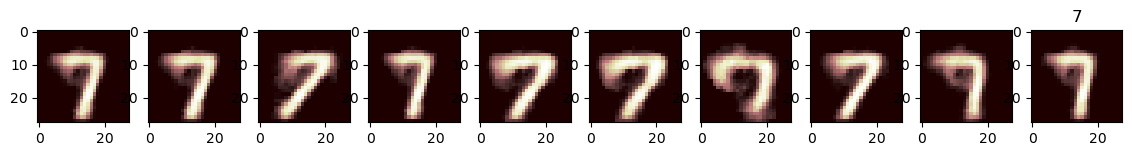

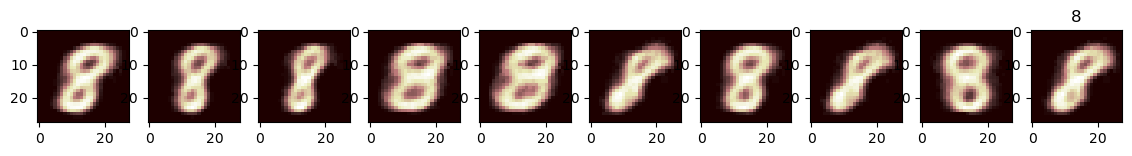

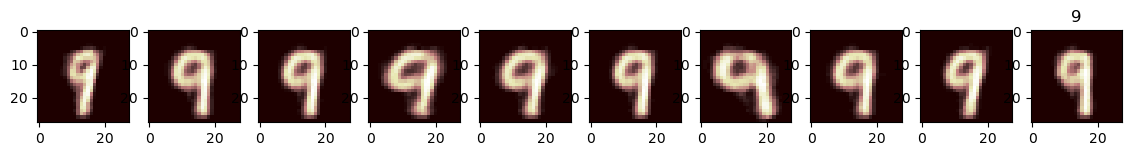

In [104]:
VAE.generate_digits()

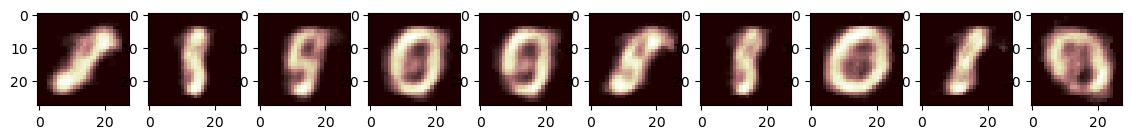

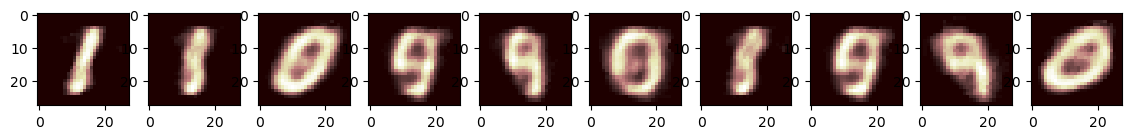

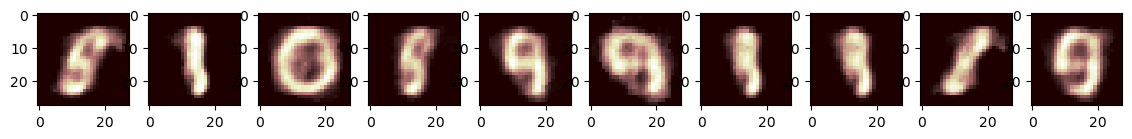

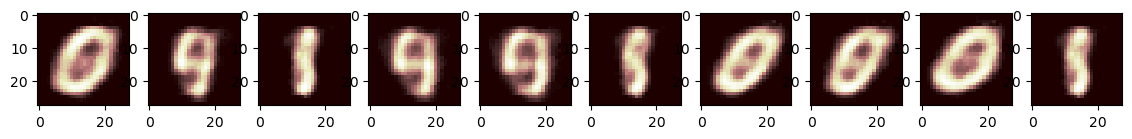

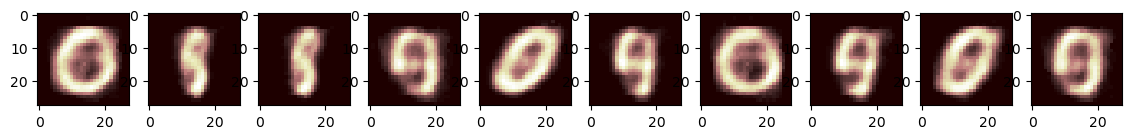

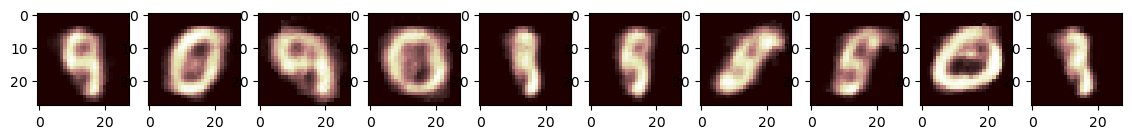

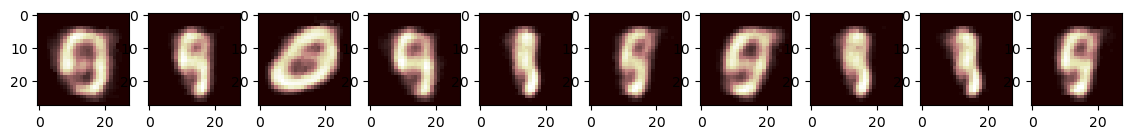

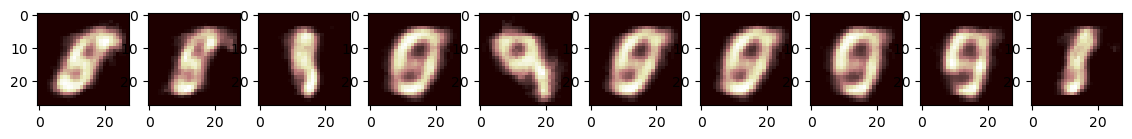

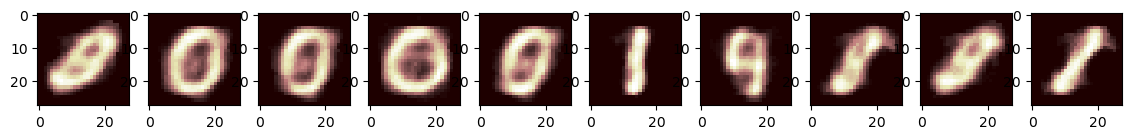

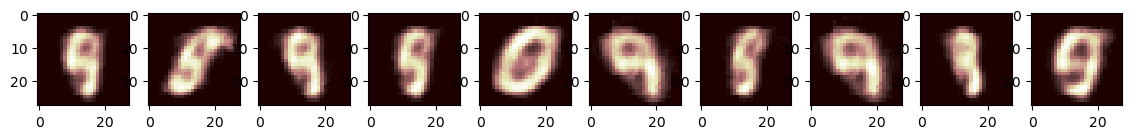

In [119]:
for j in range(10):
    fig = plt.figure(figsize=(14,10))
    with torch.no_grad():
        for i in range(10):
            z = torch.randn(2)
            y = torch.zeros(10)
            #y[3] = 1
            z_cond = torch.cat((z,y))
            img = VAE.decoder(z_cond)
            ax = fig.add_subplot(1,10,i+1)
            ax.imshow(img.reshape(28,28), cmap='pink')
    plt.show()